### Importing libraries

In [2]:
import os
import sys
import datetime
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')
from wordcloud import WordCloud
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from PyQt5.QtWidgets import (QApplication, QWidget, QVBoxLayout, QLineEdit, QTableWidget,
                             QPushButton, QTextEdit, QLabel, QGridLayout, QMessageBox, 
                             QTableWidgetItem, QMainWindow, QStackedWidget)

### 1. Data Preparation

**load csv files from dataset (using absolute paths)**

There are two data files which are provided:<br/>

Movies.csv<br/>
* movieId: ID assigned to a movie<br/>
* title: Title of a movie<br/>
* genres: pipe-separated list of movie genres.<br/>

Ratings.csv<br/>
* userId: ID assigned to a user<br/>
* movieId: ID assigned to a movie<br/>
* rating: rating by a user to a movie<br/>
* Timestamp: time at which the rating was provided.<br/>

In [5]:
current_main_dir = os.path.abspath('..')
movies_df = pd.read_csv(current_main_dir + "/data/movies.csv")
ratings_df = pd.read_csv(current_main_dir + "/data/ratings.csv")

**Preview datasets**

In [7]:
movies_df.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,16,4.0,1217897793
1,1,24,1.5,1217895807
2,1,32,4.0,1217896246
3,1,47,4.0,1217896556
4,1,50,4.0,1217896523


**Check the size of the dataset**

In [10]:
print(f"The Data Size of movies_df: {movies_df.shape}")
print(f"The Data Size of ratings_df: {ratings_df.shape}")

The Data Size of movies_df: (10329, 3)
The Data Size of ratings_df: (105339, 4)


**Display basic statistics of movies_df and ratings_df**

In [12]:
movies_df.describe()

,movieId
count,10329.000000
mean,31924.282893
std,37734.741149
min,1.000000
25%,3240.000000
50%,7088.000000
75%,59900.000000
max,149532.000000


In [13]:
ratings_df.describe()

,userId,movieId,rating,timestamp
count,105339.000000,105339.000000,105339.000000,1.053390e+05
mean,364.924539,13381.312477,3.516850,1.130424e+09
std,197.486905,26170.456869,1.044872,1.802660e+08
min,1.000000,1.000000,0.500000,8.285650e+08
25%,192.000000,1073.000000,3.000000,9.711008e+08
50%,383.000000,2497.000000,3.500000,1.115154e+09
75%,557.000000,5991.000000,4.000000,1.275496e+09
max,668.000000,149532.000000,5.000000,1.452405e+09


From the above we can draw conclusions that:

* For all the ratings which have been given, the average is 3.5, and the maximum and the minimum are 5 and 0.5 respectively
* There are 668 users who have given 149532 ratings for all movies

**Check null values in two dataframes**

In [16]:
# check null values in movies_df
pd.DataFrame({'Count for Null Values:': movies_df.isnull().sum()})

,Count for Null Values:
movieId,0
title,0
genres,0


In [17]:
# check null values in ratings_df
pd.DataFrame({'Count for Null Values:': ratings_df.isnull().sum()})

,Count for Null Values:
userId,0
movieId,0
rating,0
timestamp,0


### 2. Exploratory Data Analysis and Data Preprocessing

**Find all the unique genres in ratings**

In [20]:
# Prepare the data of genres and movie titles
movies_df['genres_list'] = movies_df['genres'].str.split('|')
unique_genres = set(g for genres in movies_df['genres_list'] for g in genres)

**Find all the unique users who made ratings**

In [22]:
unique_users_len = len(set(ratings_df['userId'].values.tolist()))
print(f"There are totally {unique_users_len} users who made ratings")

There are totally 668 users who made ratings


**Show the distribution of ratings**

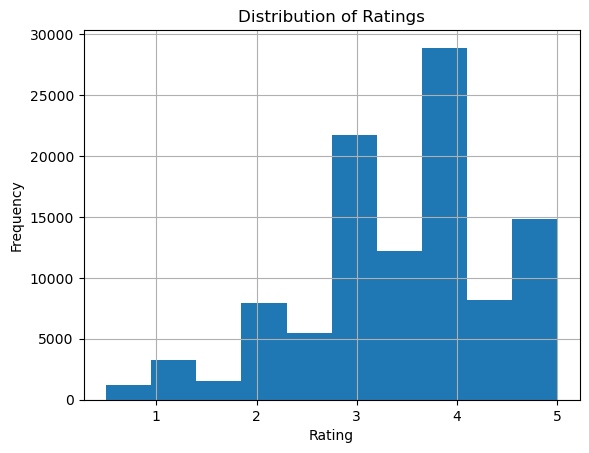

In [24]:
ratings_df['rating'].hist(bins=10)
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

From the above, we can conclude that a rating of occurs most frequently, while 0 and 1 have the least occurences.

**Display the sorted average rating by Genre**

In [27]:
genre_ratings = []
genre_ratings_df = None
# traverse every genre in unique_genres to get each genre's average ratings
for genre in unique_genres:
    # the column genres currently is a list in each cell
    genre_movies = movies_df[movies_df['genres_list'].apply(lambda g: genre in g)]
    merged = pd.merge(ratings_df, genre_movies, on='movieId')
    avg_rating = merged['rating'].mean()
    genre_ratings.append((genre, avg_rating))

# Sort the rating and display
genre_ratings = sorted(genre_ratings, key=lambda x: x[1], reverse=True)

# Extract genre and rating at the same time but also keep their relationship
genres, avg_ratings = zip(*[(item[0], item[1]) for item in genre_ratings])

# Convert these data into lists
genres = list(genres)
avg_ratings = list(avg_ratings)

# Put all info into the DataFrame to display 
genre_ratings_df = pd.DataFrame({'Genres': genres, 'Average Ratings': avg_ratings})
genre_ratings_df.head()

,Genres,Average Ratings
0,Film-Noir,3.913636
1,War,3.783202
2,Mystery,3.652043
3,Drama,3.650266
4,Documentary,3.643035


**WordCloud for Movie Genres and Movies titles**

In [29]:
movie_title_list = movies_df['title'].values.tolist()
unique_movie_titles = str(set([title_item[0:-7] for title_item in movie_title_list]))

In [30]:
# Display the WordCloud
wordcloud_genre = WordCloud(width=1500, height=800, background_color='black', min_font_size=2,
                            min_word_length=3).generate(str(unique_genres))
wordcloud_title = WordCloud(width=1500, height=800, background_color='cyan', min_font_size=2,
                            min_word_length=3).generate(unique_movie_titles)

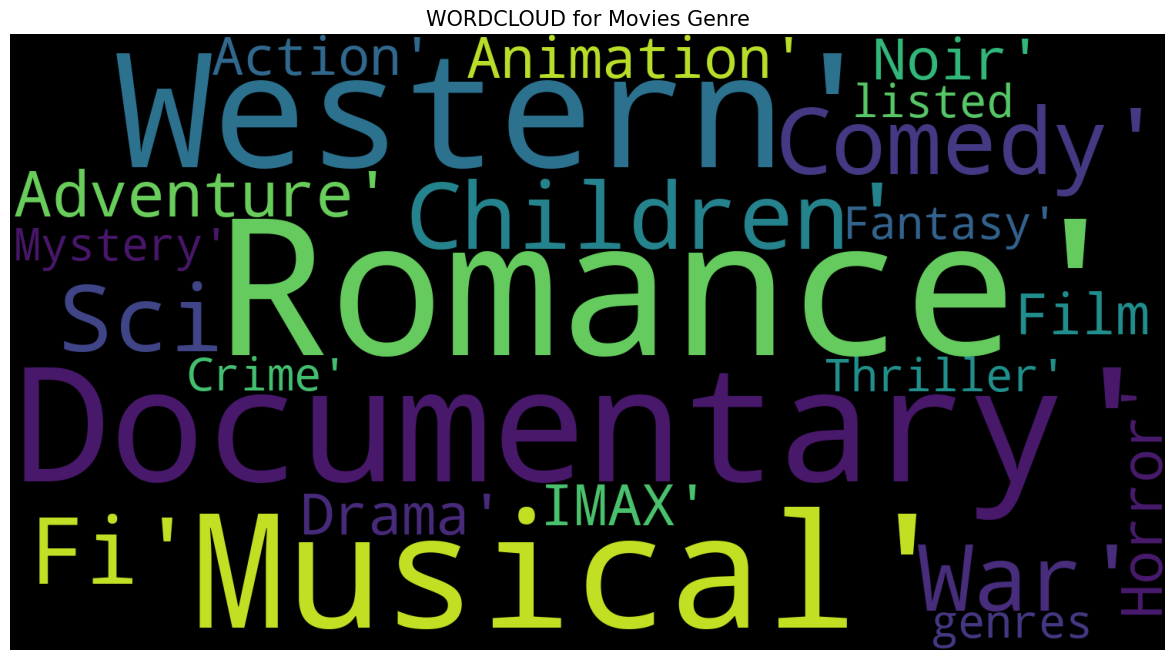

In [31]:
# Plot WORDCLOUD for movies genre
plt.figure(figsize=(20, 8))
plt.axis('off')
plt.title('WORDCLOUD for Movies Genre', fontsize=15)
plt.imshow(wordcloud_genre)
plt.show()

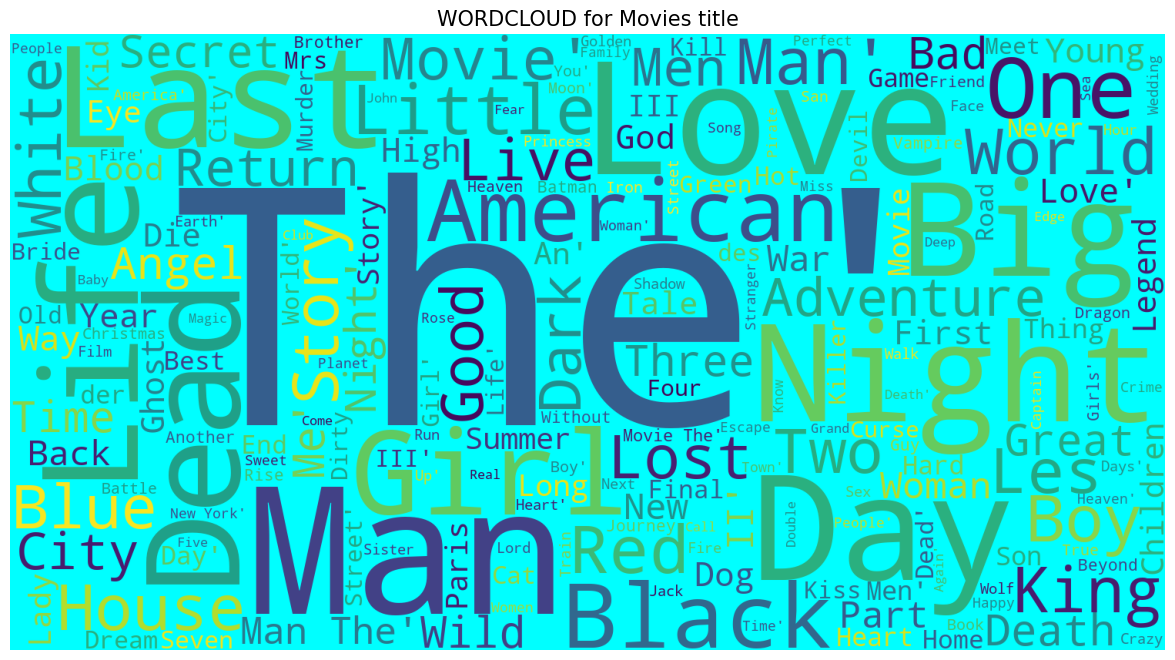

In [32]:
plt.figure(figsize=(20, 8))
plt.axis('off')
plt.title('WORDCLOUD for Movies title', fontsize=15)
plt.imshow(wordcloud_title)
plt.show()

**Show Top 20 movies with the highest average rating**

In [34]:
# Perform the left join to get the detailed movie info for all ratings
rating_movie_df = pd.merge(ratings_df, movies_df, how='left', on='movieId')
rating_movie_df.head()

,userId,movieId,rating,timestamp,title,genres,genres_list
0,1,16,4.0,1217897793,Casino (1995),Crime|Drama,"[Crime, Drama]"
1,1,24,1.5,1217895807,Powder (1995),Drama|Sci-Fi,"[Drama, Sci-Fi]"
2,1,32,4.0,1217896246,Twelve Monkeys (a.k.a. 12 Monkeys) (1995),Mystery|Sci-Fi|Thriller,"[Mystery, Sci-Fi, Thriller]"
3,1,47,4.0,1217896556,Seven (a.k.a. Se7en) (1995),Mystery|Thriller,"[Mystery, Thriller]"
4,1,50,4.0,1217896523,"Usual Suspects, The (1995)",Crime|Mystery|Thriller,"[Crime, Mystery, Thriller]"


In [35]:
# Group the data from rating_movie_df by movie titles to compute the 20 movies which have the highest ratings
rating_movie_groupby_df = rating_movie_df.groupby(['title'])[['rating']].sum()
high_rated_20 = rating_movie_groupby_df.nlargest(20, 'rating')
high_rated_20.head()

,rating
title,
"Shawshank Redemption, The (1994)",1372.0
Pulp Fiction (1994),1352.0
Forrest Gump (1994),1287.0
"Silence of the Lambs, The (1991)",1216.5
Star Wars: Episode IV - A New Hope (1977),1143.5


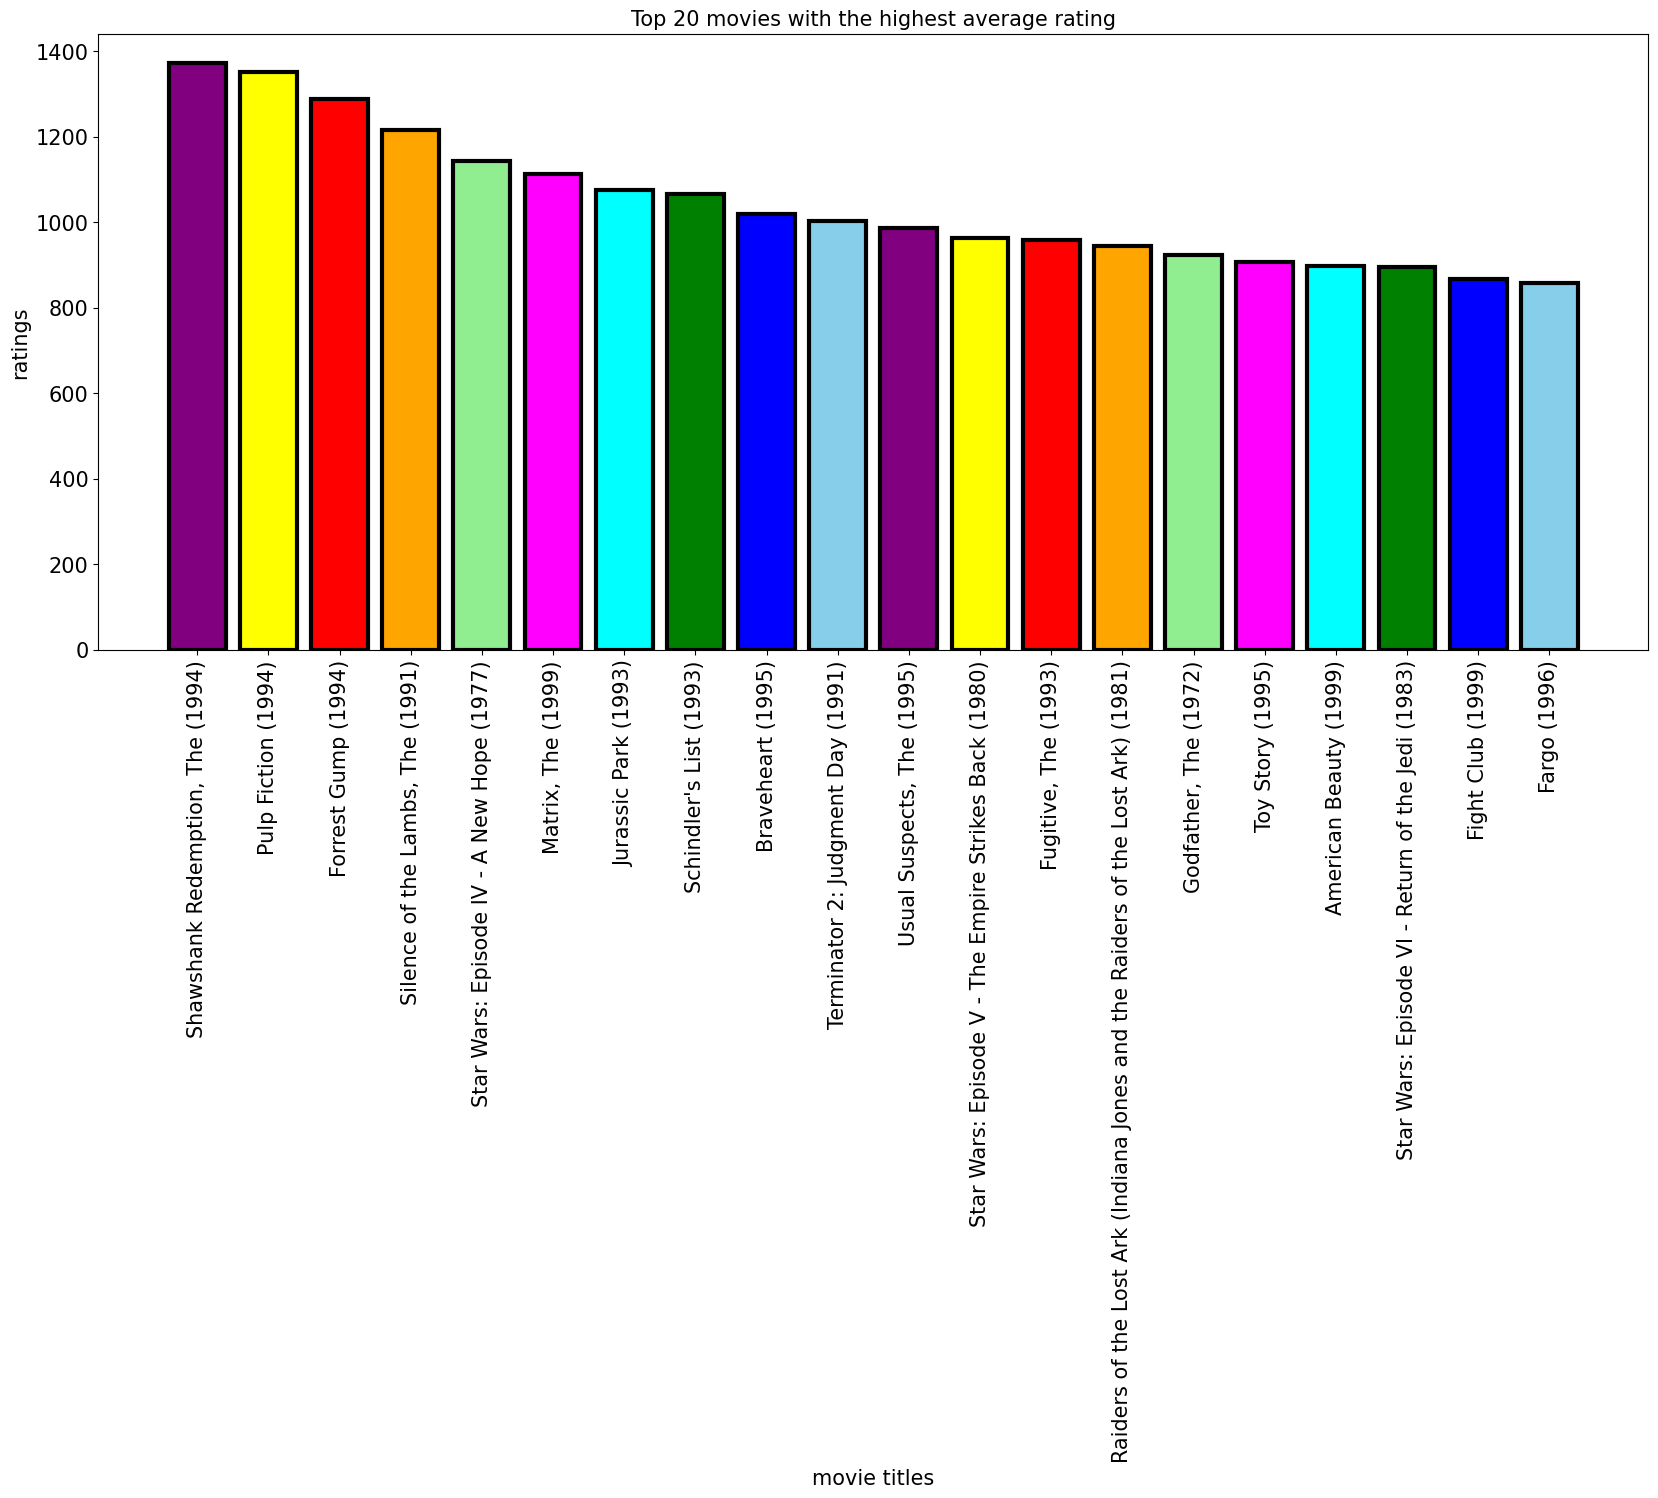

In [36]:
plt.figure(figsize=(20, 8))
plt.title('Top 20 movies with the highest average rating', fontsize=15)
colors = ['purple', 'yellow', 'red', 'orange', 'lightgreen', 'magenta','cyan', 'green', 'blue','skyblue']
plt.xlabel('movie titles', fontsize=15)
plt.ylabel('ratings', fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.bar(high_rated_20.index, high_rated_20['rating'], linewidth=3, edgecolor='black', color=colors)
plt.show()

**Show Top 20 movies with the highest number of ratings**

In [38]:
rating_movie_groupby_count_df = rating_movie_df.groupby(['title'])[['rating']].count()
high_rated_count_20 = rating_movie_groupby_count_df.nlargest(20, 'rating')
high_rated_count_20.head()

,rating
title,
Pulp Fiction (1994),325
Forrest Gump (1994),311
"Shawshank Redemption, The (1994)",308
Jurassic Park (1993),294
"Silence of the Lambs, The (1991)",290


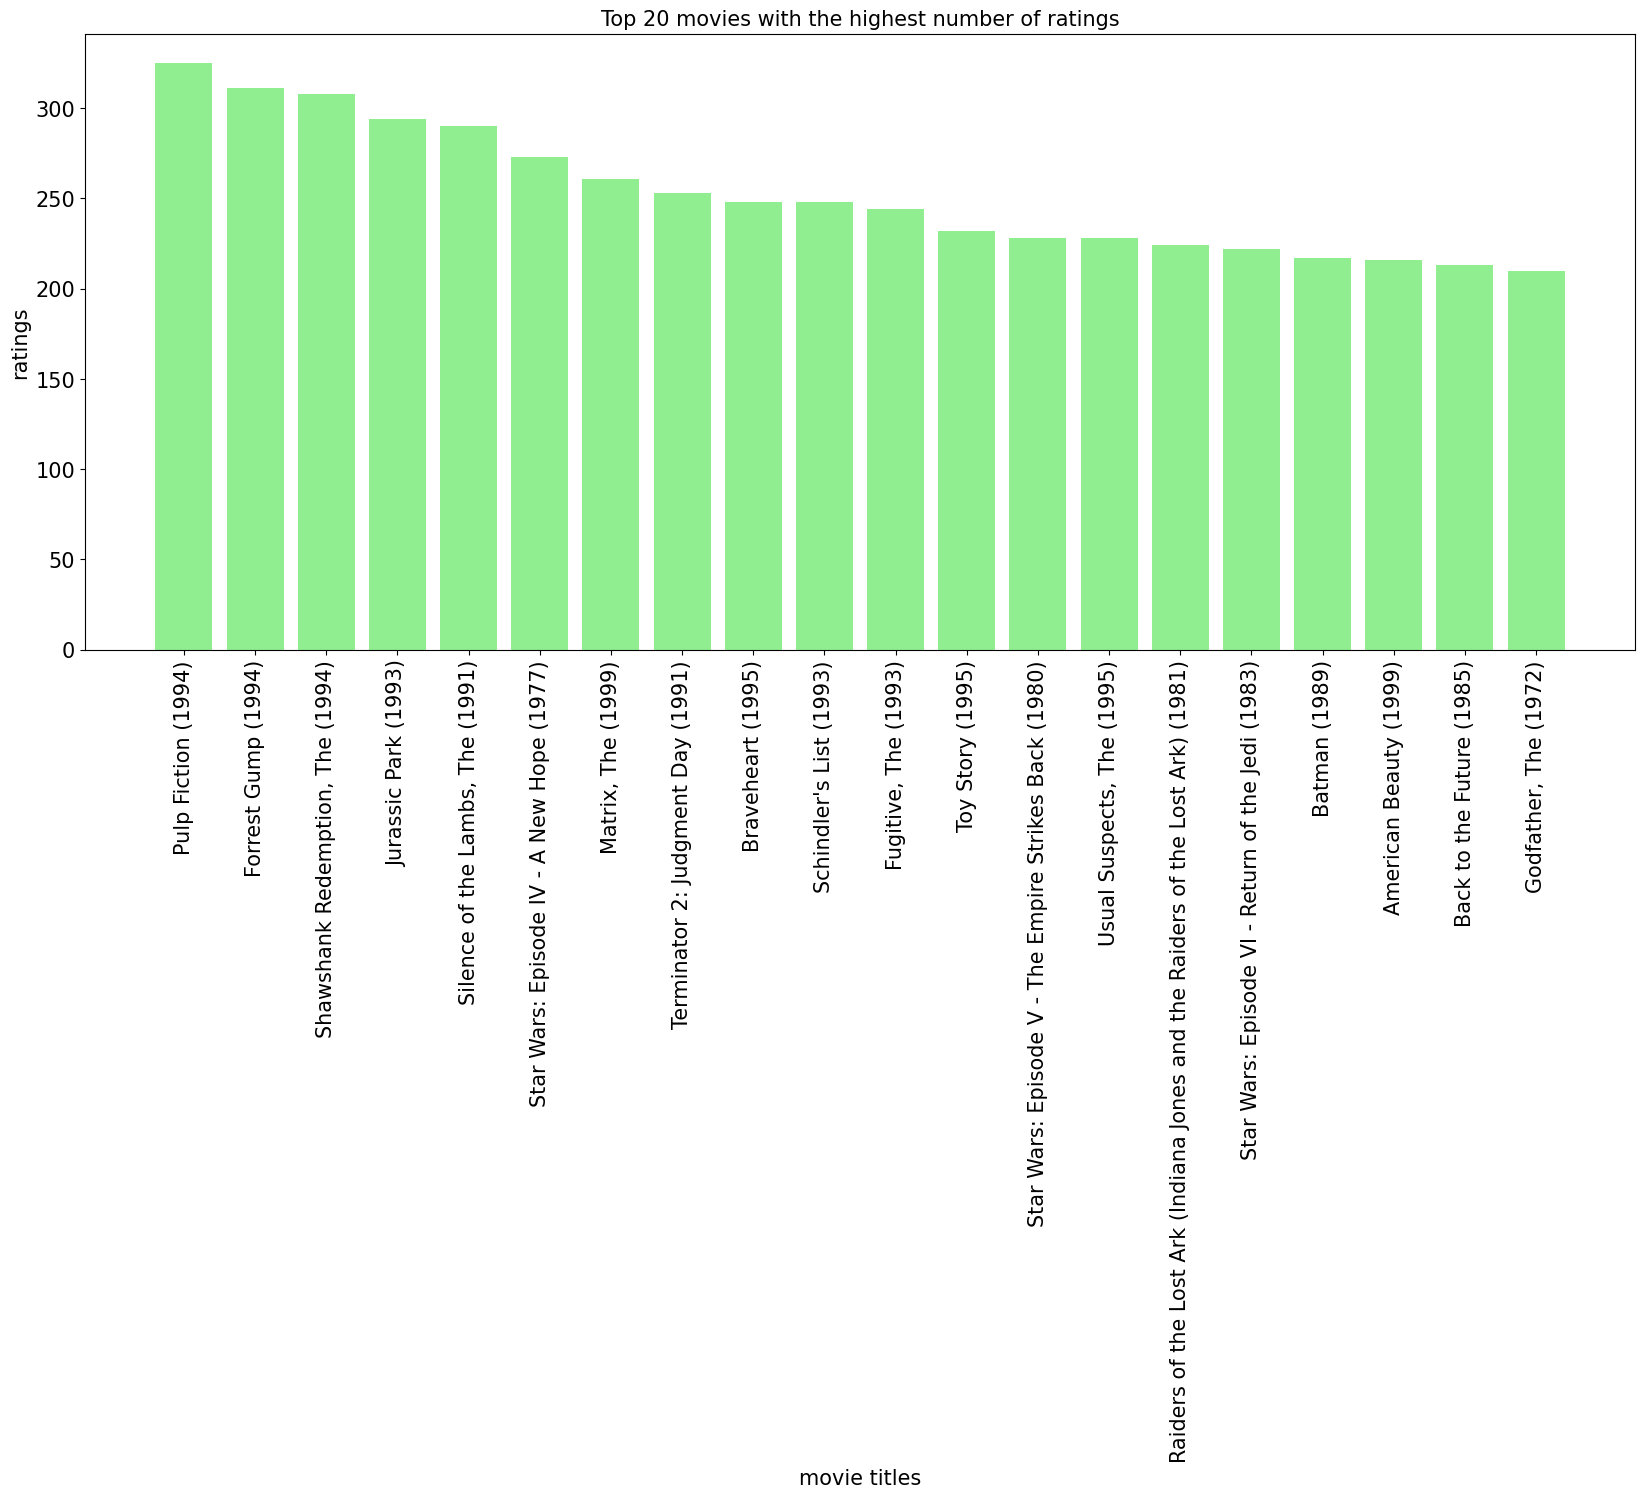

In [39]:
plt.figure(figsize=(20, 8))
plt.title('Top 20 movies with the highest number of ratings', fontsize=15)
plt.xlabel('movie titles', fontsize=15)
plt.ylabel('ratings', fontsize=15)
plt.xticks(fontsize=15, rotation=90)
plt.yticks(fontsize=15)
plt.bar(high_rated_count_20.index, high_rated_count_20['rating'], color='lightgreen')
plt.show()

In [40]:
# Remove product year in the title column in the movies_df
movies_df['title'] = movies_df['title'].transform(lambda item: item[0:-7])

### 3. Popularity-Based Recommender

In [42]:
def popularity_recommender(movies_df, ratings_df, genre, min_reviews, top_n):
    # Filter by genre (given in the parameter)
    genre_movies = movies_df[movies_df['genres_list'].apply(lambda g: genre in g)]
    # Merge with ratings (connect movies with ratings)
    merged = pd.merge(ratings_df, genre_movies, on='movieId')
    # Aggregate data
    grouped = merged.groupby('title').agg(
        avg_rating=('rating', lambda x: round(x.mean(), 6)),
        review_count=('rating', 'count')
    ).reset_index()
    # Filter by min_reviews
    filtered = grouped[grouped['review_count'] >= min_reviews]
    # Sort by avg_rating
    sorted_movies = filtered.sort_values(by='avg_rating', ascending=False).head(top_n)
    # Adding a sequential number column and make it to the 1st position
    sorted_movies = sorted_movies.set_index(pd.Series(range(1, len(sorted_movies) + 1))).reset_index()
    # Rename the column names of the dataframe sorted_movies
    sorted_movies = sorted_movies.rename(columns={'index': 'S.No',
                                                  'title': 'Movie Title',
                                                  'avg_rating': 'Average Movie Rating',
                                                  'review_count': 'Num Reviews'})
    return sorted_movies

# Example call
genre = 'Comedy'
min_reviews_thresh = 100
num_recommendations = 5
recommendations = popularity_recommender(movies_df,
                                         ratings_df,
                                         genre=genre,
                                         min_reviews=min_reviews_thresh,
                                         top_n=num_recommendations)
recommendations

,S.No,Movie Title,Average Movie Rating,Num Reviews
0,1,Monty Python and the Holy Grail,4.301948,154
1,2,Fargo,4.271144,201
2,3,"Princess Bride, The",4.163743,171
3,4,Pulp Fiction,4.160000,325
4,5,Forrest Gump,4.138264,311


### 4.Content-Based Recommender

In [44]:
def content_based_recommender(movies_df, title, top_n):
    # Prepare genre data
    movies_df['genres_str'] = movies_df['genres_list'].apply(lambda x: ' '.join(x))
    # Vectorize genres
    count_vectorizer = CountVectorizer()
    genre_matrix = count_vectorizer.fit_transform(movies_df['genres_str'])
    # Compute similarity
    cosine_sim = cosine_similarity(genre_matrix, genre_matrix)
    # Find index of the movie
    movie_idx = movies_df[movies_df['title'] == title].index[0]
    similar_movies = list(enumerate(cosine_sim[movie_idx]))
    # Sort by similarity (movie_index, similar score)
    similar_movies = sorted(similar_movies, key=lambda x: x[1], reverse=True)[1: top_n+1]
    # Get movie titles
    recommend_list = [movies_df.iloc[item[0]]['title'] for item in similar_movies]
    recommendations = pd.DataFrame({'Sl.No': range(1, len(recommend_list) + 1), 'Movie Title': recommend_list})
    return recommendations

# Example call
movie_title = 'Toy Story'
num_recommendations = 5
recommendations = content_based_recommender(movies_df, title=movie_title, top_n=num_recommendations)
recommendations

,Sl.No,Movie Title
0,1,Antz
1,2,Toy Story 2
2,3,"Adventures of Rocky and Bullwinkle, The"
3,4,"Emperor's New Groove, The"
4,5,"Monsters, Inc."


### 5.Collaborative Filtering

In [46]:
def collaborative_recommender(ratings_df, user_id, top_n, k):
    # Create user-item matrix
    user_item_matrix = ratings_df.pivot(index='userId', columns='movieId', values='rating').fillna(0)
    # Compute similarity
    user_similarity = cosine_similarity(user_item_matrix)
    # Find similar users (user_similarity[user_idx] is a list, denote the current user's similarity to others)
    user_idx = user_id - 1
    similar_users = sorted(enumerate(user_similarity[user_idx]), key=lambda x: x[1], reverse=True)[:k]
    # Get recommendations
    similar_user_indices = [user[0] for user in similar_users]
    similar_users_ratings = user_item_matrix.iloc[similar_user_indices].mean(axis=0)
    recommendations = similar_users_ratings.sort_values(ascending=False).head(top_n)
    recommended_movie_ids = recommendations.index.tolist()
    recommended_titles = movies_df[movies_df['movieId'].isin(recommended_movie_ids)]['title'].tolist()
    # Summarize all the information into a dataframe
    recommended_df = pd.DataFrame({'S.No': range(1, len(recommended_titles) + 1), 
                                   'Movie Title': recommended_titles})
    return recommended_df

# Example call
user_id = 1
num_recommendations = 5
similar_users_threshold = 100
recommended_titles = collaborative_recommender(ratings_df, user_id=user_id, top_n=num_recommendations, k=similar_users_threshold)
recommended_titles

,S.No,Movie Title
0,1,Pulp Fiction
1,2,"Shawshank Redemption, The"
2,3,Forrest Gump
3,4,Star Wars: Episode V - The Empire Strikes Back
4,5,"Matrix, The"


### 6. GUI with ipywidgets

**Build popularity-based recommender system, content-based recommender system, and collborative recommender system through creating three classes with PyQt (ipydgets is not stable)**

In [49]:
class PopularityAppPyQt(QWidget):
    def __init__(self):
        super().__init__()

        self.db = pd.DataFrame(columns=['S.No', 'Movie Title', 'Average Movie Rating', 'Num Reviews'])
        self.initUI()

    def initUI(self):
        self.setWindowTitle("Popularity-based Recommender System")

        layout = QGridLayout()

        # Genre input
        layout.addWidget(QLabel("Genre:"), 0, 0)
        self.genre_input = QLineEdit(self)
        layout.addWidget(self.genre_input, 0, 1)

        # Minimum reviews input
        layout.addWidget(QLabel("Minimum reviews threshold:"), 1, 0)
        self.min_reviews_input = QLineEdit(self)
        layout.addWidget(self.min_reviews_input, 1, 1)

        # Number of recommendations input
        layout.addWidget(QLabel("Number of recommendations:"), 2, 0)
        self.num_recommendations_input = QLineEdit(self)
        layout.addWidget(self.num_recommendations_input, 2, 1)

        # Recommend button
        self.recommend_button = QPushButton("Recommend Movies", self)
        self.recommend_button.clicked.connect(self.on_button_clicked)
        layout.addWidget(self.recommend_button, 3, 0, 1, 2)

        # Output table
        self.output_table = QTableWidget(self)
        self.output_table.setColumnCount(4)  # Number of columns
        self.output_table.setHorizontalHeaderLabels(
            ['S.No', 'Movie Title', 'Average Movie Rating', 'Num Reviews']
        )
        layout.addWidget(self.output_table, 4, 0, 1, 2)

        self.setLayout(layout)

    def on_button_clicked(self):
        genre = self.genre_input.text()
        min_reviews = self.min_reviews_input.text()
        num_recommendations = self.num_recommendations_input.text()

        if not genre or not min_reviews or not num_recommendations:
            QMessageBox.warning(self, "Error", "Please fill out all fields before recommending!")
            return

        try:
            min_reviews = int(min_reviews)
            num_recommendations = int(num_recommendations)
        except ValueError:
            QMessageBox.warning(self, "Error", "Minimum reviews and Number of recommendations must be integers!")
            return
            
        recommendations = popularity_recommender(movies_df, ratings_df, genre, min_reviews, num_recommendations)
        self.db = pd.concat([self.db, recommendations], ignore_index=True)

        self.populate_table(recommendations)

    def populate_table(self, data):
        """Populate QTableWidget with DataFrame data."""
        self.output_table.setRowCount(len(data))  # Set number of rows

        for i, row in data.iterrows():
            self.output_table.setItem(i, 0, QTableWidgetItem(str(row['S.No'])))
            self.output_table.setItem(i, 1, QTableWidgetItem(row['Movie Title']))
            self.output_table.setItem(i, 2, QTableWidgetItem(str(row['Average Movie Rating'])))
            self.output_table.setItem(i, 3, QTableWidgetItem(str(row['Num Reviews'])))

In [50]:
class ContentAppPyQt(QWidget):
    def __init__(self):
        super().__init__()

        self.db = pd.DataFrame(columns=['Sl.No', 'Movie Title'])
        self.initUI()

    def initUI(self):
        self.setWindowTitle("Content-based Recommender System")

        layout = QGridLayout()

        # Movie title input
        layout.addWidget(QLabel("Movie Title:"), 0, 0)
        self.movie_title_input = QLineEdit(self)
        layout.addWidget(self.movie_title_input, 0, 1)

        # Number of recommendations input
        layout.addWidget(QLabel("Number of recommendations:"), 2, 0)
        self.num_recommendations_input = QLineEdit(self)
        layout.addWidget(self.num_recommendations_input, 2, 1)

        # Recommend button
        self.recommend_button = QPushButton("Recommend Movies", self)
        self.recommend_button.clicked.connect(self.on_button_clicked)
        layout.addWidget(self.recommend_button, 3, 0, 1, 2)

        # Output table
        self.output_table = QTableWidget(self)
        self.output_table.setColumnCount(2)  # Number of columns
        self.output_table.setHorizontalHeaderLabels(
            ['Sl.No', 'Movie Title']
        )
        layout.addWidget(self.output_table, 4, 0, 1, 2)

        self.setLayout(layout)

    def on_button_clicked(self):
        movie_title = self.movie_title_input.text()
        num_recommendations = self.num_recommendations_input.text()

        if not movie_title or not num_recommendations:
            QMessageBox.warning(self, "Error", "Please fill out all fields before recommending!")
            return

        try:
            num_recommendations = int(num_recommendations)
        except ValueError:
            QMessageBox.warning(self, "Error", "Number of recommendations must be integers!")
            return

        recommendations = content_based_recommender(movies_df, movie_title, num_recommendations)
        self.db = pd.concat([self.db, recommendations], ignore_index=True)

        self.populate_table(recommendations)

    def populate_table(self, data):
        """Populate QTableWidget with DataFrame data."""
        self.output_table.setRowCount(len(data))  # Set number of rows

        for i, row in data.iterrows():
            self.output_table.setItem(i, 0, QTableWidgetItem(str(row['Sl.No'])))
            self.output_table.setItem(i, 1, QTableWidgetItem(row['Movie Title']))

In [51]:
class CollaborativeAppPyQt(QWidget):
    def __init__(self):
        super().__init__()

        self.db = pd.DataFrame(columns=['S.No', 'Movie Title'])
        self.initUI()

    def initUI(self):
        self.setWindowTitle("Collaborative Filtering Recommender System")

        layout = QGridLayout()

        # User ID input
        layout.addWidget(QLabel("UserID:"), 0, 0)
        self.user_id_input = QLineEdit(self)
        layout.addWidget(self.user_id_input, 0, 1)

        # Number of recommendations input
        layout.addWidget(QLabel("Number of recommendations:"), 1, 0)
        self.num_recommendations_input = QLineEdit(self)
        layout.addWidget(self.num_recommendations_input, 1, 1)

        # Threshold for similar users input
        layout.addWidget(QLabel("Threshold for similar users:"), 2, 0)
        self.thresh_similar_user_input = QLineEdit(self)
        layout.addWidget(self.thresh_similar_user_input, 2, 1)

        # Recommend button
        self.recommend_button = QPushButton("Recommend Movies", self)
        self.recommend_button.clicked.connect(self.on_button_clicked)
        layout.addWidget(self.recommend_button, 3, 0, 1, 2)

        # Output table
        self.output_table = QTableWidget(self)
        self.output_table.setColumnCount(2)  # Number of columns
        self.output_table.setHorizontalHeaderLabels(
            ['S.No', 'Movie Title']
        )
        layout.addWidget(self.output_table, 4, 0, 1, 2)

        self.setLayout(layout)

    def on_button_clicked(self):
        user_id = self.user_id_input.text()
        num_recommendations = self.num_recommendations_input.text()
        thresh_for_similar_users = self.thresh_similar_user_input.text()

        if not movie_title or not num_recommendations or not thresh_for_similar_users:
            QMessageBox.warning(self, "Error", "Please fill out all fields before recommending!")
            return

        try:
            user_id = int(user_id)
            thresh_for_similar_users = int(thresh_for_similar_users)
            num_recommendations = int(num_recommendations)
        except ValueError:
            QMessageBox.warning(self, "Error", "User ID, Number of recommendations, and threshold fo similar users must be integers!")
            return

        recommendations = collaborative_recommender(ratings_df, user_id, num_recommendations, thresh_for_similar_users)
        self.db = pd.concat([self.db, recommendations], ignore_index=True)

        self.populate_table(recommendations)

    def populate_table(self, data):
        """Populate QTableWidget with DataFrame data."""
        self.output_table.setRowCount(len(data))  # Set number of rows

        for i, row in data.iterrows():
            self.output_table.setItem(i, 0, QTableWidgetItem(str(row['S.No'])))
            self.output_table.setItem(i, 1, QTableWidgetItem(row['Movie Title']))

In [52]:
class MainApp(QMainWindow):
    def __init__(self):
        super().__init__()
        self.setWindowTitle("Recommendation System")

        # Central widget to hold the stacked layout
        self.central_widget = QWidget()
        self.setCentralWidget(self.central_widget)

        # Layout for navigation
        self.main_layout = QVBoxLayout()

        # Navigation buttons
        self.popularity_button = QPushButton("Popularity-Based Recommender")
        self.popularity_button.clicked.connect(self.show_popularity)
        self.main_layout.addWidget(self.popularity_button)

        self.content_button = QPushButton("Content-Based Recommender")
        self.content_button.clicked.connect(self.show_content)
        self.main_layout.addWidget(self.content_button)

        self.collaborative_button = QPushButton("Collaborative Filtering Recommender")
        self.collaborative_button.clicked.connect(self.show_collaborative)
        self.main_layout.addWidget(self.collaborative_button)

        # Stacked widget to switch between UIs
        self.stacked_widget = QStackedWidget()

        # Add the individual recommendation systems as pages
        self.popularity_ui = PopularityAppPyQt()
        self.content_ui = ContentAppPyQt()
        self.collaborative_ui = CollaborativeAppPyQt()

        self.stacked_widget.addWidget(self.popularity_ui)
        self.stacked_widget.addWidget(self.content_ui)
        self.stacked_widget.addWidget(self.collaborative_ui)

        self.main_layout.addWidget(self.stacked_widget)

        self.central_widget.setLayout(self.main_layout)

    def show_popularity(self):
        self.stacked_widget.setCurrentWidget(self.popularity_ui)

    def show_content(self):
        self.stacked_widget.setCurrentWidget(self.content_ui)

    def show_collaborative(self):
        self.stacked_widget.setCurrentWidget(self.collaborative_ui)

In [83]:
if __name__ == "__main__":
    app = QApplication(sys.argv)

    # Main application window
    main_window = MainApp()
    main_window.resize(800, 600)
    main_window.show()

    sys.exit(app.exec_())

SystemExit: 0

### 7. Final Results Display

**Results from Popularity-Based Recommender**<br/>
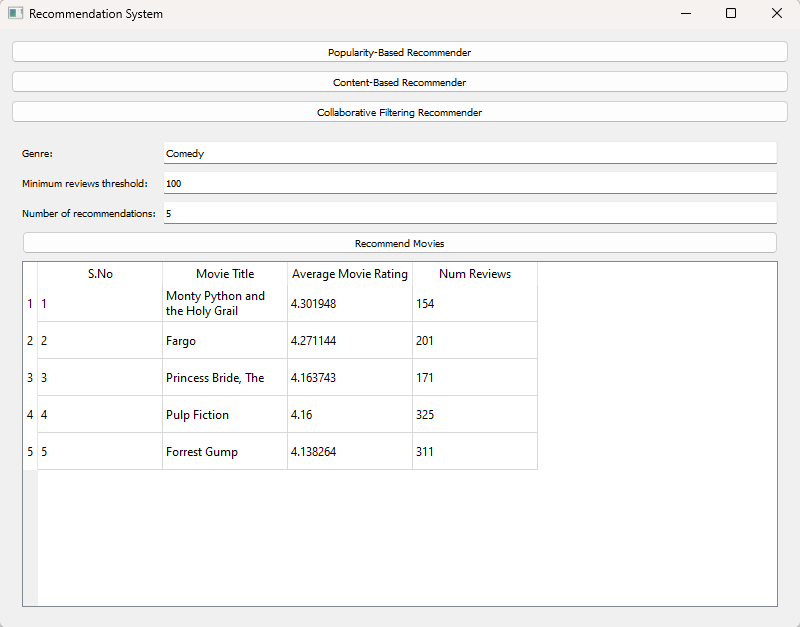

**Results from Content-Based Recommender**<br/>
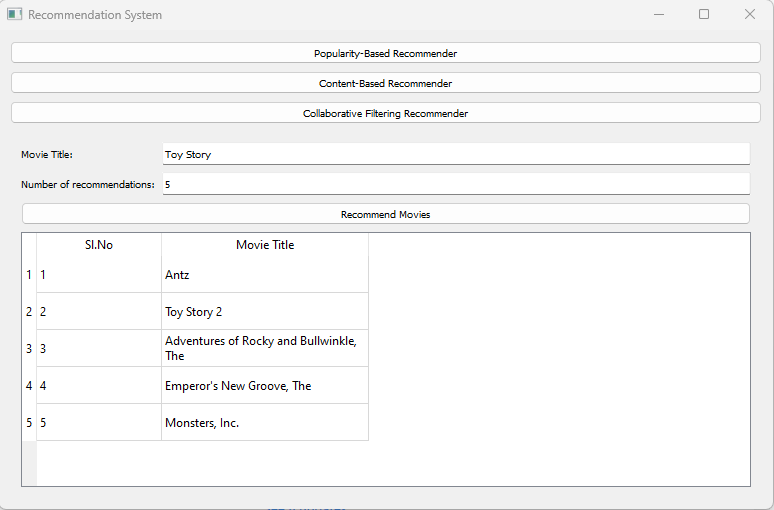

**Results from Collaborative Filtering Recommender**
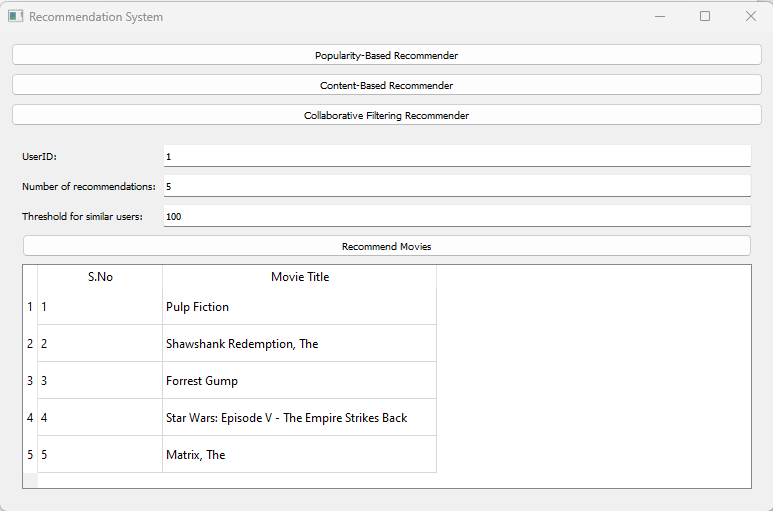